In [6]:
# Import libraries
import sys
import shelve
from time import time
sys.path.append('../mycode')

import numpy as np
import pandas as pd

import seaborn as sns

# from mycode/
import utils
import myStats
import myPlots 

In [2]:
# Load data and models

#----    Original data    ----#
d_old = shelve.open("../outputs/01_data_explore")
df = d_old['df'].copy()
d_old.close()

#----    data split    ----#
d_old = shelve.open("../outputs/02_feature_engineering")
df_train = d_old['df_train'].copy()
df_test = d_old['df_test'].copy()
d_old.close()


#----    Logistic Regression    ----#
d_old = shelve.open("../outputs/03_logistic_reg")

# Test Data
logistic_X_test = d_old['logistic_X_test'].copy()
logistic_X_test_adv = d_old['logistic_X_test_adv'].copy()
y_test = d_old['logistic_y_test'].copy()

# Models
fit_logistic = d_old['best_fit_logistic']
fit_logistic_adv = d_old['best_fit_logistic_adv']

d_old.close()

#----    Decsion Tree    ----#
d_old = shelve.open("../outputs/04_decision_tree")

# Test Data
tree_X_test = d_old['tree_X_test'].copy()
tree_X_test_adv = d_old['tree_X_test_adv'].copy()

# Models
fit_tree = d_old['best_fit_tree']
fit_tree_adv = d_old['best_fit_tree_adv']

d_old.close()

#----    Random Forest    ----#

d_old = shelve.open("../outputs/05_random_forest")

# Data are the same of tree models

# Models
fit_forest = d_old['best_fit_forest']
fit_forest_adv = d_old['best_fit_forest_adv']

d_old.close()

#----    XGBoost    ----#

d_old = shelve.open("../outputs/06_xgboost")

# Test Data
xgb_X_test = d_old['xgb_X_test'].copy()
xgb_X_test_adv = d_old['xgb_X_test_adv'].copy()

# Models
fit_xgb = d_old['best_fit_xgb']
fit_xgb_adv = d_old['best_fit_xgb_adv']

d_old.close()


/Users/claudio/.local/share/virtualenvs/weather-report-eCmZ_q2Y/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Weather Report

The aim of the analysis is to predict whether it will rain tomorrow. In this report- we provide a detailed description of all the analysis steps and we discuss the results.

The report is structured as follow:

- Section 1 Descriptive Analysis
- Section 2 Feature Engineering
- Section 3 Analysis Plan
- Section 4 Analysis Results
- Section 5 Model Comparison
- Section 6 Discussion


## Section 1 Descriptive Analysis

Refer to `analysis/01_data_explore.py` for the full code. 

The initial data is formed by 142193 entries on 23 columns. In particular, there are:

- **Date time variable**: Date
- **Categorical variables**: Location, WindGustDir, WindDir9am, WindDir3pm, and RainToday.
- **Numerical variables**: MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed- WindSpeed9am- WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, and Temp3pm.
- **Outcome variable**: RainTomorrow.



### Categorical Variables

For each categorical variable, I checked that all values are legit (no misspelled entries).

Values frequencies for each categorical variable is presented below.


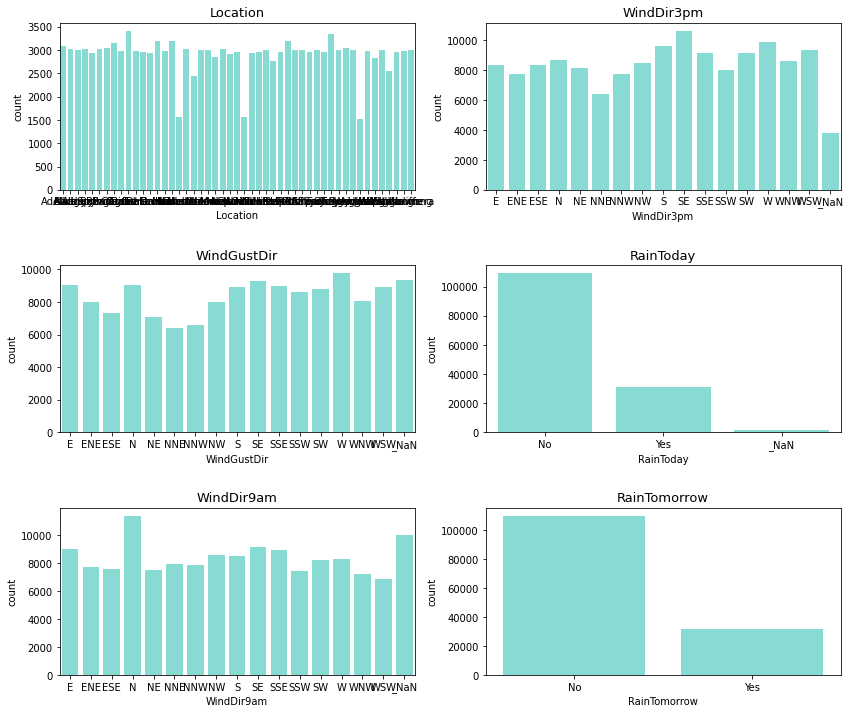

In [52]:
cat_columns = df.select_dtypes(include='object').columns
myPlots.plot_categorical(df, columns = cat_columns)

Note that all the categorical variables except for `Location`have missing data. Proportion of missing values for each variable is presented below.

In [53]:
cat_columns = df.select_dtypes(include='object').columns
df[cat_columns].isnull().sum() / len(df)

Location        0.000000
WindGustDir     0.065615
WindDir9am      0.070418
WindDir3pm      0.026570
RainToday       0.009888
RainTomorrow    0.000000
dtype: float64

### Continuos Variables

#### Missing  Values

First, I checked missing data. Proportion of missing values for each variable is presented below.

In [55]:
numeric_columns = df.select_dtypes(include=np.number).columns[0:16]
df[numeric_columns].isnull().sum() / len(df)

MinTemp          0.004480
MaxTemp          0.002265
Rainfall         0.009888
Evaporation      0.427890
Sunshine         0.476929
WindGustSpeed    0.065193
WindSpeed9am     0.009480
WindSpeed3pm     0.018496
Humidity9am      0.012476
Humidity3pm      0.025388
Pressure9am      0.098556
Pressure3pm      0.098324
Cloud9am         0.377353
Cloud3pm         0.401525
Temp9am          0.006358
Temp3pm          0.019171
dtype: float64

Note that `Evaporation`, `Sunshine`, `Cloud9a`, and `Cloud3pm` have a very high proportion of missing values.

 First, I considered to remove these variables from the analysis. However, further inspection revealed that the proportion of missing data varies a lot depending on `Location`. Some locations have no values whereas other have a limited number of missing values or none missing values (see below).

 Therefore, I decided to include these variables in the analysis.

In [57]:
# Check missing values proportion within to location
pd.concat([df.Location, df[['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']].isnull()], axis=1)\
    .groupby('Location').mean()

,Evaporation,Sunshine,Cloud9am,Cloud3pm
Location,,,,
Adelaide,0.466343,0.450485,1.000000,1.000000
Albany,0.092838,0.167772,0.011605,0.230438
Albury,1.000000,1.000000,0.574228,0.530056
AliceSprings,0.069614,0.168591,0.109535,0.118113
BadgerysCreek,1.000000,1.000000,1.000000,1.000000
Ballarat,1.000000,1.000000,0.179657,0.343791
Bendigo,0.609426,1.000000,0.317732,0.252802
Brisbane,0.006011,0.015185,0.000316,0.000633
Cairns,0.114123,0.142570,0.061914,0.068942


#### Distribution

The distribution of each numerical variable is presented below.

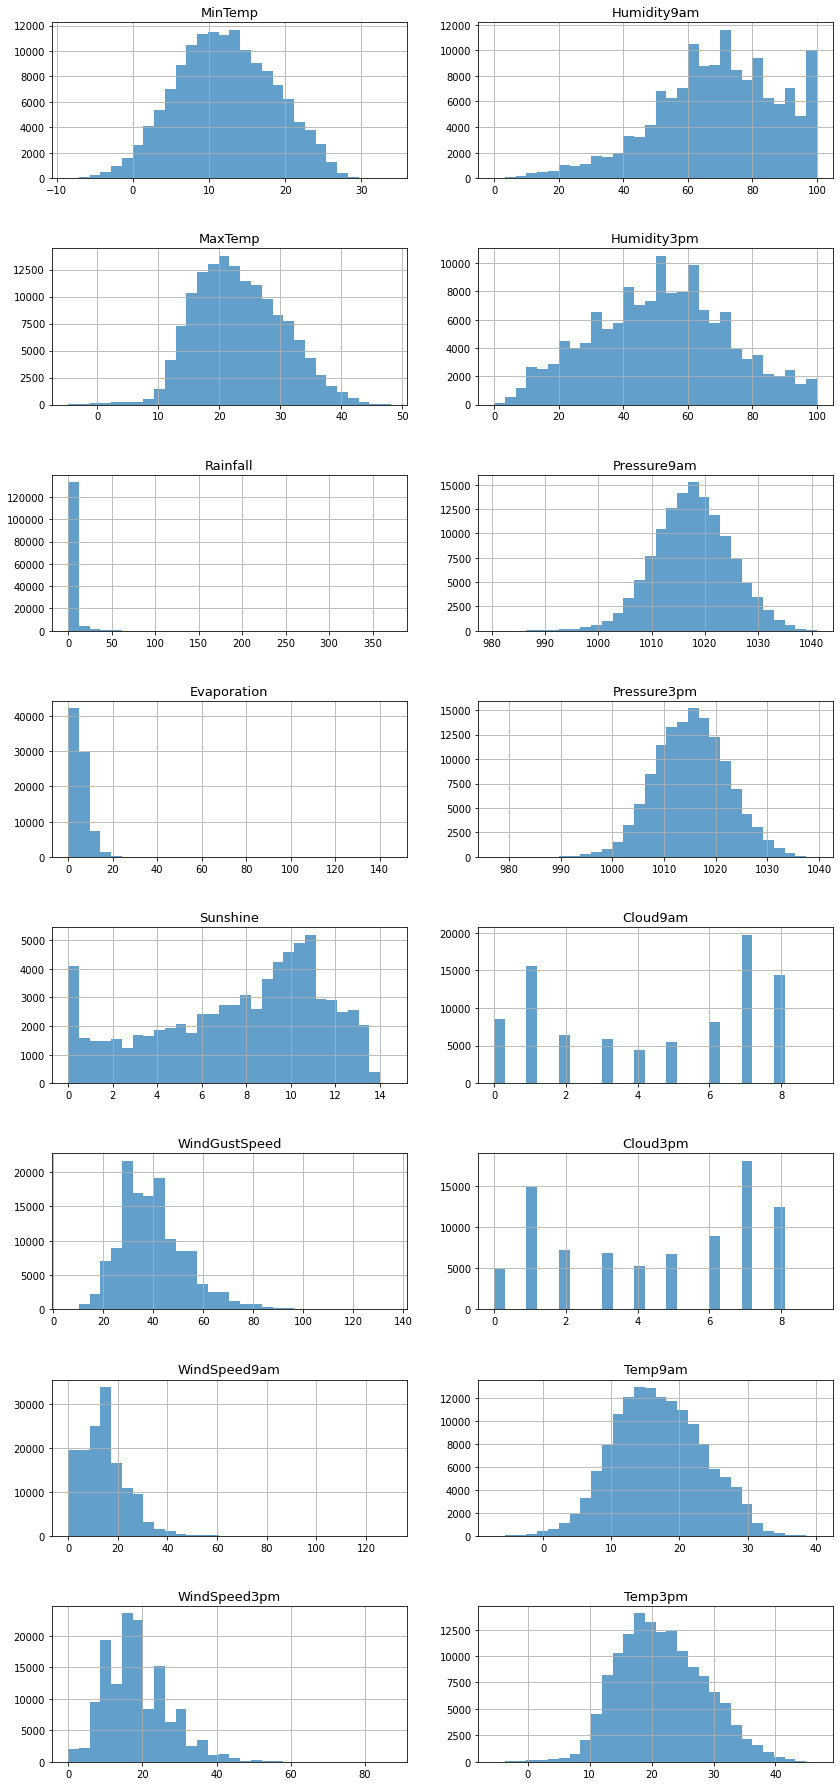

In [58]:
myPlots.plot_descriptive(df, columns=numeric_columns)

All values are legit (no errors os odds values).

However, note how:

- `Evaporation`, `WindGustSpeed`, `WindSpeed9am`, and `WindSpeed3pm` have a positively skewed distribution. 
- `Rainfall` has a zero-inflated positively skewed distribution. 
- `Cloud9am` and `Cloud3pm` have  a bimodal-distribution, but there is a kind of symmetry.

I computed the log-transformed values (adding +1 before applying log) for `Evaporation`, `WindGustSpeed`, `WindSpeed9am`, `WindSpeed3pm`, and `Rainfall`. Log-transformed variables are presented below

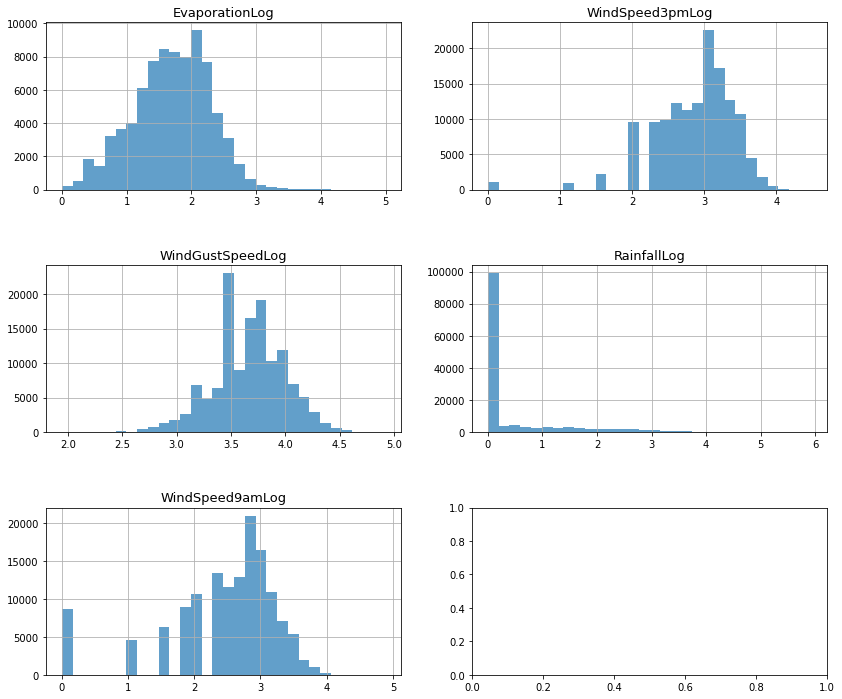

In [59]:
myPlots.plot_descriptive(df,\
     columns=['EvaporationLog', 'WindGustSpeedLog',
     'WindSpeed9amLog', 'WindSpeed3pmLog', 'RainfallLog'])

Log-transformed variables behave slightly better. Of course this do not solve the zero-inflated distribution of `Rainfall`. 

#### Correlation

Considering correlation between variables, there are some important clusters of highly correlates variables.

- **Temperature.** High correlation between `MinTemp`, `MaxTemp`, `Temp9am`, `Temp3pm`. To overcome these issues I computed the difference between `MaxTemp - MinTemp` and the difference between `Temp3pm - Temp9am`.

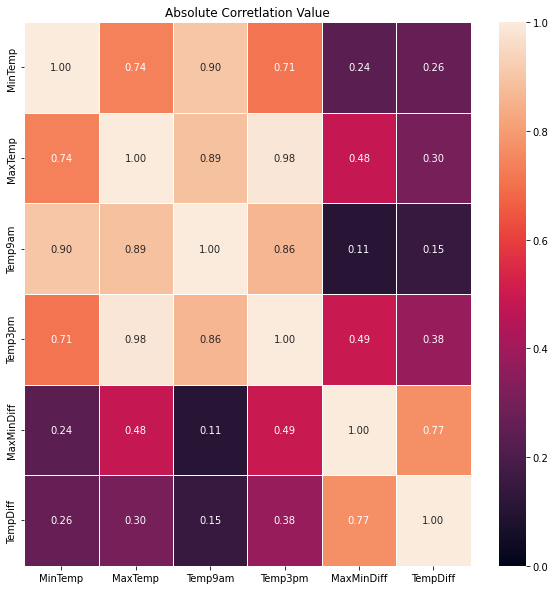

In [71]:
plt.figure(figsize=(10,10))
sns.heatmap(df[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'MaxMinDiff', 'TempDiff']]\
    .corr().abs(), annot=True, fmt = '.2f', linewidths=.5, vmin=0)\
    .set_title('Absolute Corretlation Value');

- **Pressure.** High correlation between `Pressure9am`, and `Pressure3pm`. To overcome these issues I computed the difference.

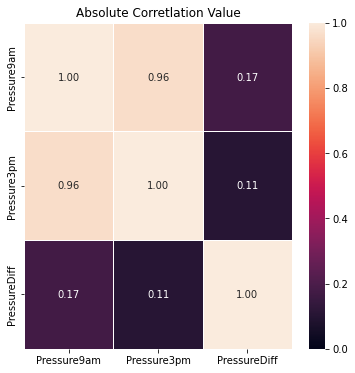

In [70]:
plt.figure(figsize=(6,6))
sns.heatmap(df[['Pressure9am', 'Pressure3pm', 'PressureDiff']]\
    .corr().abs(), annot=True, fmt = '.2f', linewidths=.5, vmin=0)\
    .set_title('Absolute Corretlation Value');

- **Humidity.** High correlation between `Humidity9am`, and `Humidity3pm`. To overcome these issues I computed the difference.

Text(0.5, 1.0, 'Absolute Corretlation Value')

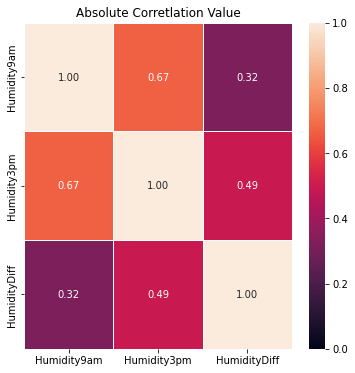

In [67]:
plt.figure(figsize=(6,6))
sns.heatmap(df[['Humidity9am', 'Humidity3pm', 'HumidityDiff']]\
    .corr().abs(), annot=True, fmt = '.2f', linewidths=.5, vmin=0)\
    .set_title('Absolute Corretlation Value');

Computing these new `Diff` variables allow to reduce the issue with collinearity between variables.

### Date Variable

From the Date variable I computed the year and the ISO week of the year. I considered weeks instead of months to allow more flexibility (se discussion for final considerations about this).

Data are collected between 2007 and 2017.

Considering observations by year according to `Location`, we can observe some small differences. For example:

- Only Canberra has observations for 2007.
- Katherine, Nhil, and Uluru have observation after 2013.

In [68]:
grouped_location = df.groupby(['Location'])
grouped_location['Year'].value_counts().unstack()


Year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Location,,,,,,,,,,,
Adelaide,NaN,166.0,362.0,359.0,325.0,321.0,307.0,351.0,360.0,366.0,173.0
Albany,NaN,31.0,365.0,365.0,335.0,334.0,334.0,361.0,364.0,362.0,165.0
Albury,NaN,30.0,364.0,358.0,330.0,334.0,333.0,360.0,365.0,366.0,171.0
AliceSprings,NaN,31.0,365.0,365.0,335.0,335.0,337.0,365.0,365.0,362.0,171.0
BadgerysCreek,NaN,NaN,359.0,333.0,332.0,332.0,334.0,356.0,358.0,349.0,175.0
Ballarat,NaN,31.0,365.0,364.0,329.0,335.0,336.0,363.0,365.0,364.0,176.0
Bendigo,NaN,31.0,365.0,365.0,335.0,335.0,337.0,365.0,365.0,364.0,172.0
Brisbane,NaN,183.0,362.0,361.0,331.0,334.0,336.0,362.0,358.0,363.0,171.0
Cairns,NaN,31.0,365.0,365.0,335.0,334.0,337.0,362.0,365.0,318.0,176.0


Moreover, I checked differences in days to evaluate whether there are large gaps between observations. This will be relevant for the missing data imputation

### Outcome

Considering the outcome variable, it is important to note the imbalance between the two values.

In [69]:
utils.my_count(df['RainTomorrow'])

,count,prop
No,110316,0.775819
Yes,31877,0.224181


## Section 2 Feature Engineering

Refer to `analysis/02_feature_engineering.py` for the full code. 

### Data Split

To split the data into training and testing sets, I have the two following options:

- Selecting observations randomly stratifying for the outcome.
- Selecting observations according to a chronological criteria.

As the aim is to predict future observations, I preferred to split the observations according to the year. In particular:

- **Train Data.** Observations from 2007 to 2015 (included).
- **Test Data.** Observations from 2016 to 2017 (included).

In this way I can evaluate more appropriately the model ability to predict future observations. 

If I had sample observations randomly, the model could have learned relations related to specific past conditions that do not apply to future years. For example, suppose May 2012 was an exceptionally raining month, the model could learn that and predict more correctly observations in that specific month, but this is not important fro future years.

By training the models on data from 2007 to 2015 and test them on *future data*, I can evaluate model more correctly. In this way, I simulate the same conditions that reflect the model aims.

Major drawback of this approach is that if years 2016-2017 are exceptionally different from the previous andd future year results will be misleading. 

To evaluate representativeness of the test data, I compared descriptive statistics iin the test data and in the train data. Overall values are very similar except that mean minimum temperature and maximum temperature are 1 degree higher (climate change? Very interesting).

In particular, considering the outcome variable, proportions of No and Yes are almost exactly the same, see below. [Perfect! stratification or other adjustments are not required.]


In [80]:
print('Train\n', utils.my_count(df_train['RainTomorrow']))
print('\nTest\n', utils.my_count(df_test['RainTomorrow']))

Train
      count      prop
No   90288  0.776878
Yes  25931  0.223122

Test
      count      prop
No   20028  0.771079
Yes   5946  0.228921


Finally, we can check the proportion of training and testing data that is close to 80% and 20%, see below.

In [88]:
[round(val/ len(df),4) for val in [len(df_train), len(df_test)]]

[0.8173, 0.1827]

I preferred this division, compared to 2007-2014 vs 2015-2017 (that would have lead to 70% and 30% data split), because for some locations there are only observations from 2013.

### Missing Values

#### Categorical Variables

I replaced missing values with a new entry (`'Missing'`) in all categorical variables. In this way, missing values will be modelled separately and, ideally, they should not be informative (i.e., selected by the model as important variables).

#### Numerical Variables

I choose the following procedure to impute missing data in the training set.

- Compute trimmed (5%) mean value within each location for all variables except for `Rainfall`, `Evaporation`, `RainfallLog`, and `EvaporationLog`. Given their highly skewed distribution, I preferred to consider the median.

  Note that if no data wa available for a specific location, I considered the mean of the trimmed means (or medians).

- For `MinTemp`, `MaxTemp`, `Temp9am`, `Temp3pm`, `TempDiff`, and `MaxMinDiff` first I checked if data was available for dates close to the day with a missing value. If *today* was missing, but *yesterday* and *tomorrow* (up to two days of difference) data were available, I computed *today* value as the mean of *yesterday* and *tomorrow* values.

  Rationale is that temperature values are very similar in days close to each other. In this way, I can try to retrieve the actual value rather that averaging large range of values that could be less informative.

  Remaining missing values are imputed considering the previously computed trimmed mean according to `Location`. 

- For all other variables, missing values are imputed considering the trimmed mean according to `Location` and median for `Rainfall`, `Evaporation`, `RainfallLog`, and `EvaporationLog`.

  I did not tried to consider *yesterday* and *tomorrow* data for other variables ass daily variation is much higher than for temperature values.


### Scaling Data

I used the `StandardScaler` from `sklearn.preprocessing` to standardize variables obtaining Z values.

I preferred Z values to Min-Max standardization to allow comparing variable importance directly considering their coefficients.

### Coding Wind Direction

Wind direction has 16 levels (+ 1 for missing). I tried to code wind direction information differently using two numerical variables. For each wind direction I considered the Cosine and Sine value of the angle relative to North.

![Wind Direction](image/wind-dir.png)

For the missing data I considered 0 for both Sine and Cosine. In this way, the different combinations of Cosine and Sine values can identify all the wind directions.

The advantage of this approach is that I use two numerical variables instead of a categorical variables with 16 +1 levels. Moreover, using numerical values similar wind directions (e.g., NNW, N, NNE) can be *combined*.

The main draw back of this approach is that interaction is needed to correctly codify all the wind direction. See final discussion for further considerations.


### Test Data

Regarding the Testing data, I

- Set missing values of categorical variables to `'Missing`
- Impute missing values of numerical variables using the training trimmed means (or medians) according to location.
- Scale numerical variables using `StandardScaler` from `sklearn.preprocessing` according to train mean and SD values.

## Section 3 Analysis Plan

I tried different approaches to see which model performs better on the current problem. In particular, I used:

- Logistic Regression
- Decision Tree (CART)
- Random Forest
- XGBoost

For each approach, I fitted two models:

- **Simple Model** using the original variables (or log transformed).
- **Advance Model** using the `Diff` variables to limit the collinearity problems in temperature, pressure, and humidity measures. Using the the Sine and Cosine variables to encode wind direction information.

  The rationale is to try encode the information better than the original variables.

The actual sets of variables included in each model are slightly different depending on the approach specific characteristics. For example,

- `Year` is considered in the logistic model model but not in the other models. This because logistic can estimate a trend valid for feature years, whereas trees based algorithms are step functions, so prediction on future years trend do not have much sense.
- In the logistic model, scaled values are considered to facilitate model estimation ane enhance results interpretability. Instead, in the trees based algorithms, values are considered on the original scale to facilitate interpretability (trees are not affected by scaling).


### Data Encoding 

Categorical variables are encoded using the `OneHotEncoder` from `sklearn.preprocessing` (dummy variables).

### Outcome Metric

Let's create some contextual information to choose the appropriate outcome metric.

I imagined that I need this model to decide whether to go to the office by bike or by bus. If it rains and I go with the bike my laptop could be damaged (high cost). If I use the bus and it is a sunny day a waste the ticket money (low cost). All this to say tat false negative (i.e., predict sun but it is raining) are more costly than false positive (predict raining but it is sunny). I need to limit false negative.

Given my specific aim and the output class imbalance, I chose as metric of interest the f2 score. 

### Grid Search

To find the optimal model hyper-parameters, I considered the predicted error using a cross validation approach with 5 folds in all models, except for the Random Forest models where out-of-bag error (OOB) was considered instead.

I used grid-search, trying to optimize combinations of parameters in different subsequent steps. In particular:

- **Logistic Models** are estimated using the `'lbfgs'` solver and `'l2'` penalty. Grind search was used to find the optimal values of class weight and the penalization parameter.
- **Decision Trees (CART)** are estimated considering the Gini criterion and `'best'` splitter. Grind search was used to find the optimal max tree depth and class weight.
- **Random Forests** are estimated considering the Gini criterion and `'best'` splitter. Grind search was used to find the optimal max tree depth and class weight.


Note that in all models class weights was an important hyper-parameter given the output class imbalance.

#### Logistic





Model is estimated using the `'lbfgs'` solver and `'l2'` penalty. Grind search was used to find the optimal values of class_weight (`{0:1, 1:6}`) and penalization parameter  (`.1`).

Model scores are reported below.

In [3]:
myStats.get_score_report(fit_logistic, y_test, logistic_X_test)

Confusion Matrix
         Pred_y pred_y
              0      1
True_y 0  13194   6834
       1    800   5146

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.66      0.78     20028
           1       0.43      0.87      0.57      5946

    accuracy                           0.71     25974
   macro avg       0.69      0.76      0.67     25974
weighted avg       0.83      0.71      0.73     25974


F2 Score
     fbeta0    fbeta1  fbeta_macro  fbeta_weight
0  0.701018  0.719439     0.710228      0.705235


Model coefficients ordered by absolute value. 

,coefficient,value
11,Pressure3pmScale,-1.327316
118,RainToday_Missing,1.220236
9,Humidity3pmScale,1.215057
10,Pressure9amScale,0.928540
57,Location_Townsville,-0.869240
...,...,...
39,Location_Moree,0.021055
66,Location_Woomera,-0.012209
71,WindGustDir_N,-0.006580
56,Location_SydneyAirport,-0.005563


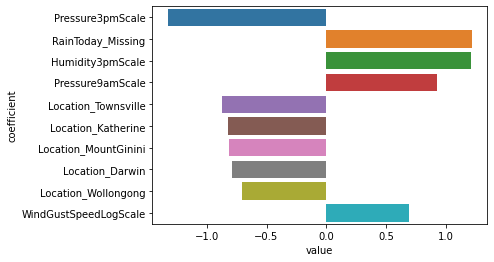

In [11]:
coef_logisitc = myStats.get_coef_importance(
    classifier = fit_logistic,
    col_names = logistic_X_test.columns
    )
sns.barplot(data = coef_logisitc.head(10), x = 'value', y = 'coefficient')
coef_logisitc

#### Advanced Model

Variables included in the model

- Categorical: 
    - `Location` 
    - `WindGustDir`
    - `WindDir9am`
    - `WindDir3pm`
    - `RainToday`
- Numerical: 
    - `MaxMinDiffScale`
    - `MaxTempScale`
    - `RainfallLogScale` 
    - `EvaporationLogScale`
    - `SunshineScale`
    - `WindGustSpeedLogScale`
    - `WindSpeed9amLogScale`
    - `WindSpeed3pmLogScale`
    - `HumidityDiffScale`
    - `Humidity3pmScale`
    - `PressureDiffScale`
    - `Pressure3pmScale`
    - `Cloud9amScale`
    - `Cloud3pmScale`
    - `Temp9amScale`
    - `TempDiffScale`
    - `YearScale`
    - `WeekScale`

Compared to before, I considered the `Diff` variables for temperature, pressure and humidity measures. Note that I did not included the wind direction sine and cosine variables because the model is additive and I would require interaction.

Again, the model is estimated using the `'lbfgs'` solver and `'l2'` penalty. Grind search was used to find the optimal values of class_weight (`{0:1, 1:6.5}`) and penalization parameter  (`.1`).

Model scores are reported below.

In [12]:
myStats.get_score_report(fit_logistic_adv, y_test, logistic_X_test_adv)

Confusion Matrix
         Pred_y pred_y
              0      1
True_y 0  12798   7230
       1    723   5223

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     20028
           1       0.42      0.88      0.57      5946

    accuracy                           0.69     25974
   macro avg       0.68      0.76      0.67     25974
weighted avg       0.83      0.69      0.72     25974


F2 Score
     fbeta0    fbeta1  fbeta_macro  fbeta_weight
0  0.683413  0.720672     0.702043      0.691942


Model coefficients ordered by absolute value. 

,coefficient,value
9,Humidity3pmScale,1.248342
118,RainToday_Missing,1.056688
57,Location_Townsville,-0.751561
41,Location_MountGinini,-0.727016
31,Location_Darwin,-0.685013
...,...,...
39,Location_Moree,0.011296
26,Location_Cairns,0.009705
56,Location_SydneyAirport,-0.005902
104,WindDir3pm_Missing,0.005485


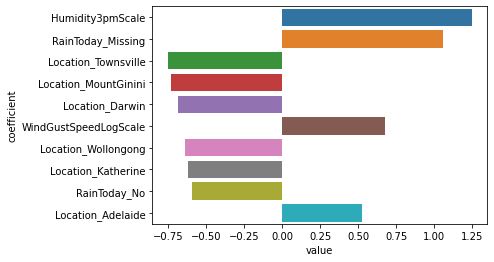

In [13]:
coef_logisitc_adv = myStats.get_coef_importance(
    classifier = fit_logistic_adv,
    col_names = logistic_X_test_adv.columns
    )
sns.barplot(data = coef_logisitc_adv.head(10), x = 'value', y = 'coefficient')
coef_logisitc_adv

The advanced  model is slightly better

###